Query Benchmarking
==================

This notebook is just to help set up a list of query templates to see the performance impact of various features and options. Actual performance analysis will be in other notebooks.

- no facets
- faceting on Domain
- normal facet sets needed for the UI (min_facets)


In [44]:
# Collections to trial:
if 'endpoints' not in locals():
    endpoints = {}
    
endpoints['fc2013'] = "http://solr.api.wa.bl.uk/solr/NPLD-FC2013-20190220"
endpoints['fc2016'] = "http://solr.api.wa.bl.uk/solr/NPLD-FC2016-20190226"
endpoints['dc2015'] = "http://solr.api.wa.bl.uk/solr/NPLD-DC2015-20190311"

if 'results' not in locals():
    returns = {}

# Prevent web proxies from interfering:
proxies = {
  "http": None,
  "https": None,
}


In [45]:
import os.path
import shutil
import random

def generate_top_terms(path, endpoint):
    terms_query = "{}/terms?sort=count&terms.fl=text&terms.limit=10000&wt=json"
    r = requests.get(terms_query.format(endpoint), proxies=proxies, stream=True)
    if r.status_code == 200:
        with open(path, 'wb') as f:
            r.raw.decode_content = True
            shutil.copyfileobj(r.raw, f)

path = 'top-terms.json'

if not os.path.isfile(path):
    generate_top_terms(path, 'http://solr.api.wa.bl.uk/solr/NPLD-FC2016-20190226_shard1_replica2')

with open(path) as f:
    results = json.load(f)
all_search_terms = results['terms']['text'][::2]
random.shuffle(all_search_terms)
print(all_search_terms)

['fewer', 'investigation', 'sky', 'printing', 'correspondent', 'persons', 'painting', 'detail', 'recommends', 'upton', 'android', 'mg', 'death', 'lgbt', 'speak', 'particulars', 'samsung', 'destroyed', 'decide', 'labels', 'neu', '18th', 'achievement', 'photography', '12th', 'fri', 'weights', 'arsene', 'studio', 'towers', 'rental', 'epetitions', 'ward', 'letting', 'editions', 'leap', 'powell', "city's", 'kill', 'banking', 'petrol', 'network', 'preservation', 'catches', 'memorial', 'mother', 'workers', 'pockets', 'voices', 'gather', 'ballet', 'leicestershire', '77', 'kids', 'murphy', 'supplied', 'meeting', 'recovering', 'abandoned', 'superstar', 'slash', 'ghana', 'raised', 'pushing', 'asks', 'broken', 'pole', 'vietnam', 'writer', 'subject', 'des', 'either', 'nndr', 'centenary', '3,750pcm', 'cycle', 'parker', 'convertible', 'individuals', 'futuna', 'ideas', 'shropshire', 'applied', 'angel', 'minimal', 'map', 'trips', 'funeral', 'lighting', 'féin', 'conversion', 'haven’t', 'caps', '17', 'bu

In [ ]:
q = {}


# As facets that appear not to contribute to the search results:
q['min_facets'] = "{}/select?q={}&\
defType=edismax&\
start=0&rows=50&\
sort=score+desc&\
qf=text&\
pf=text&\
fq=%28type%3A%22Web+Page%22%29&\
hl=true&hl.fl=content&\
facet=true&\
facet.field=public_suffix&\
facet.field=type&\
facet.field=domain&\
facet.field=collection&\
facet.field=%7B%21ex%3DfilterSecondLayer%2CfilterFirstLayer%7Daccess_terms&\
wt=json&\
version=2.2"

# Min facets but no filtering:
q['min_facets_no_filter'] = "{}/select?q={}&\
defType=edismax&\
start=0&rows=50&\
sort=score+desc&\
qf=text&\
pf=text&\
hl=true&hl.fl=content&\
facet=true&\
facet.field=public_suffix&\
facet.field=type&\
facet.field=domain&\
facet.field=collection&\
facet.field=%7B%21ex%3DfilterSecondLayer%2CfilterFirstLayer%7Daccess_terms&\
wt=json&\
version=2.2"

# Min facet right down to one facet:
q['min_facet_domain'] = "{}/select?q={}&\
defType=edismax&\
start=0&rows=50&\
sort=score+desc&\
qf=text&\
pf=text&\
fq=%28type%3A%22Web+Page%22%29&\
hl=true&hl.fl=content&\
facet=true&\
facet.field=domain&\
wt=json&\
version=2.2"

# No facets:
q['no_facets'] = "{}/select?q={}&\
defType=edismax&\
start=0&rows=50&\
sort=score+desc&\
qf=text&\
pf=text&\
fq=%28type%3A%22Web+Page%22%29&\
hl=true&hl.fl=content&\
wt=json&\
version=2.2"

# No facets no filter:
q['no_facets_no_filter'] = "{}/select?q={}&\
defType=edismax&\
start=0&rows=50&\
sort=score+desc&\
qf=text&\
pf=text&\
hl=true&hl.fl=content&\
wt=json&\
version=2.2"


import requests
import json
import pandas as pd

search_terms = all_search_terms.copy()

def run_queries(endpoint):

    print("BEGIN")

    q_type = []
    q_term = []
    q_hits = []
    q_time = []
    q_url = []

    for i in range(1,num_iters):
        for key in q:
            #
            search_term = search_terms.pop()
            #
            r = requests.get(q[key].format(endpoint, search_term), proxies=proxies)
            results = json.loads(r.text)
            if r.status_code == 200:
                hits = results.get('response',{}).get('numFound',None)
                if hits is None:
                    #print(r.text)
                    hits = results['grouped']['url']['matches']
                print(search_term, key, r.status_code, r.elapsed.total_seconds(), hits)
                # Store
                if hits > 0:
                    q_type.append(key)
                    q_term.append(search_term)
                    q_hits.append(hits)
                    q_url.append(r.url)
                    q_time.append(r.elapsed.total_seconds())
            else:
                print(r.text)
                
    print("DONE")
    
    q_data = {
        'type': q_type,
        'term': q_term,
        'hits': q_hits,
        'url': q_url,
        'time': q_time
    }

    return pd.DataFrame(q_data)


# number of iterations to run:
num_iters = 50

cid = 'fc2016'

results[cid] = run_queries(endpoints[cid]) 


BEGIN
150,000 min_facets 200 4.027689 13530417
awesome min_facets_no_filter 200 2.741074 3481786
beth min_facet_domain 200 2.163044 3698406
cultural no_facets 200 2.697973 9529742
legacy no_facets_no_filter 200 2.604497 9790477


We can now plot the results...

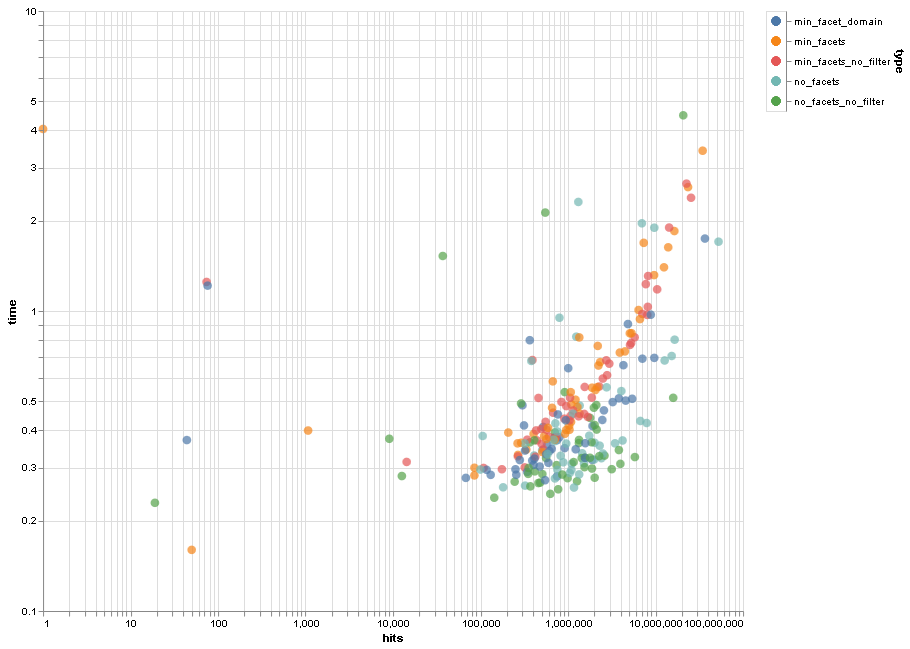

In [50]:
#!pip install altair vega
import altair as alt
alt.renderers.enable('notebook')

def make_plot(df):
    # Based on https://altair-viz.github.io/user_guide/interactions.html#selection-targets-fields-and-encodings
    selection = alt.selection_multi(fields=['type'])
    color = alt.condition(selection,
                          alt.Color('type:N', legend=None),
                          alt.value('lightgray'))

    scatter = alt.Chart(df).mark_circle(size=75).encode(
        alt.X('hits', scale=alt.Scale(type='log', base=10)),
        alt.Y('time', scale=alt.Scale(type='log', base=10)),
        color=color,
        tooltip=['term', 'type', 'hits', 'time']
    ).properties(
        width=700,
        height=600
    ).add_selection(
        selection
    )

    legend = alt.Chart(df).mark_circle(size=75).encode(
        y=alt.Y('type', axis=alt.Axis(orient='right')),
        color=color
    ).add_selection(
        selection
    )

    return scatter | legend



#c['fc2015r']['results'] = df_fc2015r
#

make_plot(results[cid])

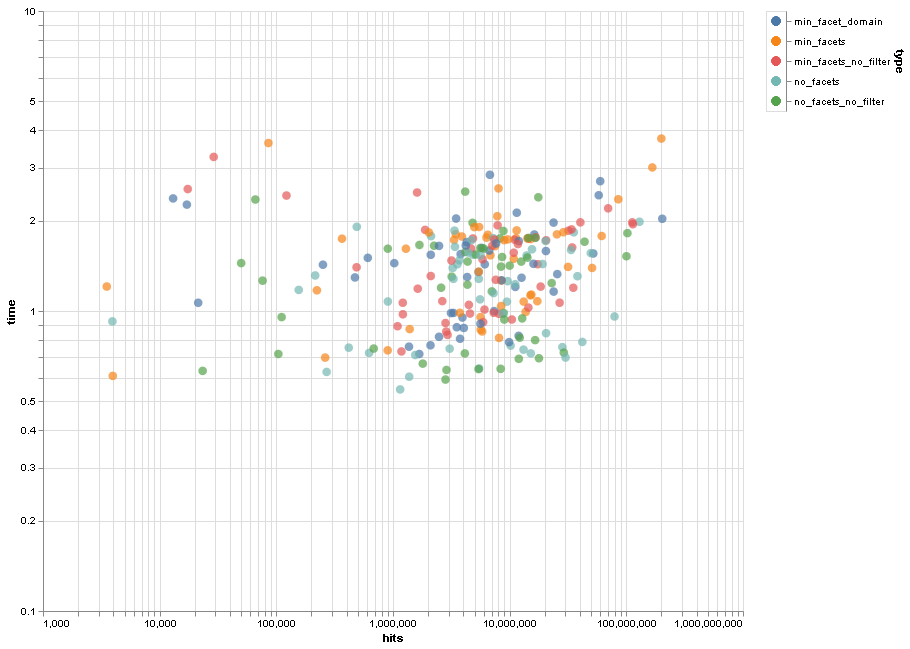

In [51]:
make_plot(results['dc2015'])